# Electron PSD
author: Louis Richard

Script to plot electron PSD around pitch angles 0, 90, and 180 deg and PSD versus pitch angle L1b brst data 

In [1]:
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

from astropy.time import Time
from pyrfu.pyrf import resample, time_clip
from pyrfu.mms import get_data, get_pitch_angle_dist

## Define time interval and spacecraft index

In [2]:
tint_r = ["2015-10-30T05:15:20.000", "2015-10-30T05:16:20.000"]
mms_id = 1

## Load data

In [3]:
vdf_e = get_data("pde_fpi_brst_l2", tint_r, mms_id)
b_xyz = get_data("b_dmpa_fgm_brst_l2", tint_r, mms_id)
sc_pot = get_data("v_edp_brst_l2", tint_r, mms_id)

Loading mms1_des_dist_brst...
Loading mms1_fgm_b_dmpa_brst_l2...
Loading mms1_edp_scpot_brst_l2...


## Convert PSD units to s^3/km^6

In [4]:
vdf_e.data.data *= 1e36

## Resample spacecraft potential to VDF sampling

In [5]:
sc_pot = resample(sc_pot, vdf_e.data)

/Users/louisr/opt/anaconda3/lib/python3.8/site-packages/pyrfu/pyrf/resample.py:223: UserWarning: Using averages in resample
  warnings.warn("Using averages in resample", UserWarning)


## Produce a single PAD at a selected time

In [6]:
tint = "2015-10-30T05:15:45.731587000"

pad_vdf_e = get_pitch_angle_dist(vdf_e, b_xyz, tint=tint_r)
pad_vdf_e = pad_vdf_e.sel(time=tint)

idx = np.argmin(abs(sc_pot.time.data - Time(tint, format="isot").datetime64))
energy_pad = pad_vdf_e.energy.data[0, :] - sc_pot.data[idx, ...]
thetas_pad = pad_vdf_e.theta.data[0, ...]
pad_data_e = pad_vdf_e.data.data[0, ...]

pad_data_e[pad_data_e == 0.] = np.nan

/Users/louisr/opt/anaconda3/lib/python3.8/site-packages/pyrfu/pyrf/resample.py:223: UserWarning: Using averages in resample
  warnings.warn("Using averages in resample", UserWarning)
100%|██████████| 12/12 [00:04<00:00,  2.51it/s]


## Plot

<IPython.core.display.Javascript object>


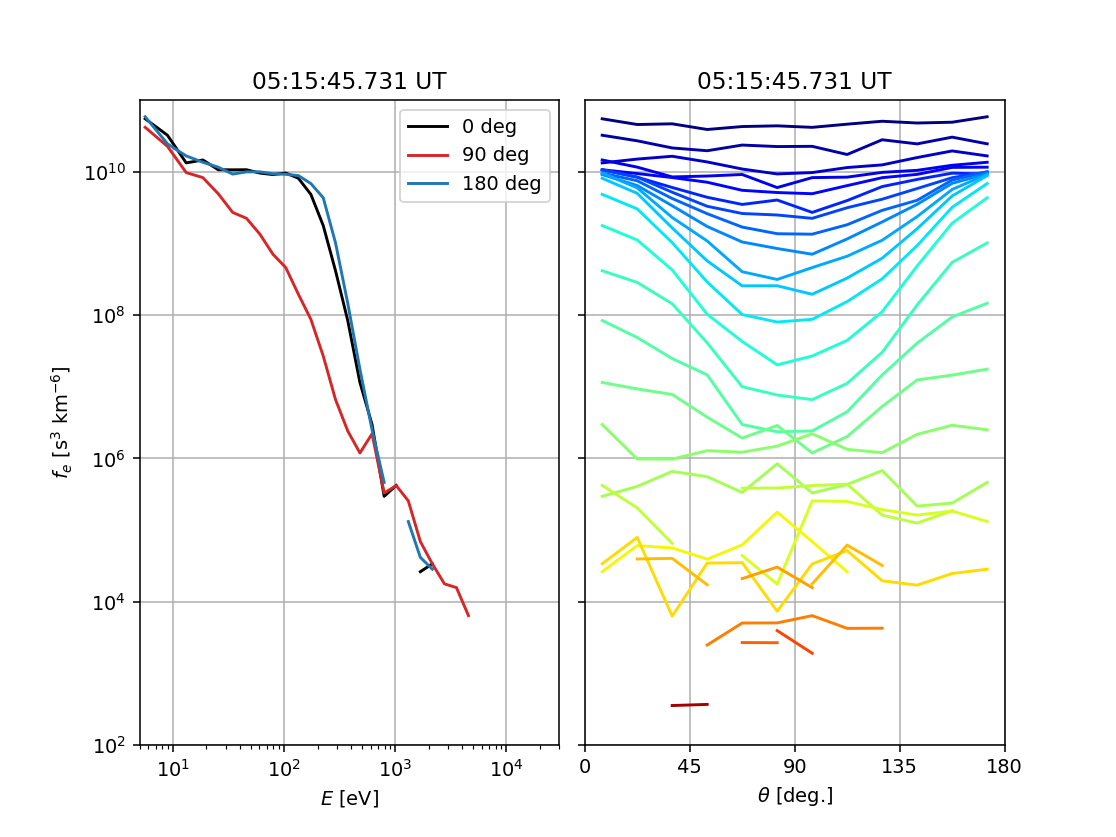

Text(0.5, 1.0, '05:15:45.731 UT')

In [8]:
%matplotlib notebook
f, axs = plt.subplots(ncols=2, sharey="all", figsize=(8, 6))
f.subplots_adjust(wspace=.06)

y_range = [10 ** 2, 10 ** np.ceil(np.nanmax(np.nanmax(np.log10(pad_data_e))))]

for i, color, ang in zip([0, 6, -1], ["k", "tab:red", "tab:blue"], [0, 90, 180]):
    axs[0].loglog(energy_pad, pad_data_e[:, i], color=color, label=f"{ang} deg")
    
axs[0].set_xlim([5, 3e4])
axs[0].set_ylim(y_range)
axs[0].set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5])
axs[0].set_xlim([5, 3e4])
axs[0].set_ylabel("$f_e$ [s$^3$ km$^{-6}$]")
axs[0].set_xlabel("$E$ [eV]")
axs[0].legend(loc="upper right", frameon=True)
axs[0].grid(which="major")
axs[0].set_title("{} UT".format(tint[11:23]))

colors = pl.cm.jet(np.linspace(0, 1, len(energy_pad)))

for (i, energy), color in zip(enumerate(energy_pad), colors):
    axs[1].semilogy(thetas_pad, pad_data_e[i, :], color=color)
    
axs[1].set_xlim([0, 180])
axs[1].set_xlabel("$\\theta$ [deg.]")
axs[1].set_xticks([0, 45, 90, 135, 180])
axs[1].grid(which="major")
axs[1].set_title("{} UT".format(tint[11:23]))